# Regression example using PT-MELT
This is a basic regression example using the models in PT-MELT.

Requires the following additional packages:
* ipykernel
* scikit-learn
* matplotlib
* torchinfo

In [1]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [2]:
# Use sklearn scaling libraries to normalize the data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_normalizer = StandardScaler()
y_normalizer = StandardScaler()

x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

# Hyperparameters
Set consistent hyperparameters for all models for comparisons sake.

In [3]:
# General hyperparameters
n_epochs = 300
batch_size = 32
loss = "mse"
learn_rate = 1e-3
l1_reg = 0
l2_reg = 0
act_fun = "relu"
dropout = 0.1
input_dropout = 0.1
batch_norm = False
batch_norm_type = "ema"
output_activation = "linear"

width = 8
depth = 2

# ResNet specific hyperparameters
layers_per_block = 4

# Make a history dict for storing metrics
history = {"loss": [], "val_loss": []}

## Artificial Neural Network (ANN)
Create and train an ANN using PT-MELT.

In [4]:
from ptmelt.models import ArtificialNeuralNetwork
from torchinfo import summary
import torch
from torch import optim


# Create the model
ann_model = ArtificialNeuralNetwork(
    num_features=n_features,
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    batch_norm_type=batch_norm_type,
    output_activation=output_activation,
)


# Build the model and print the summary
ann_model.build()
print(summary(ann_model, input_size=(1, n_features)))

# Define the loss function and optimizer for training
criterion = ann_model.get_loss_fn(loss="mse", reduction="mean")
optimizer = optim.Adam(ann_model.parameters(), lr=learn_rate)


Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [1, 3]                    --
├─ModuleDict: 1-1                        --                        --
│    └─Dropout: 2-1                      [1, 10]                   --
│    └─DenseBlock: 2-2                   [1, 8]                    --
│    │    └─ModuleDict: 3-1              --                        160
│    └─DefaultOutput: 2-3                [1, 3]                    --
│    │    └─Linear: 3-2                  [1, 3]                    27
│    │    └─Identity: 3-3                [1, 3]                    --
Total params: 187
Trainable params: 187
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Create the data holder for training/validation (the test set should be held separate from any model training)
dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
dataset_val = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).float())

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [6]:
# Fit the model using the built-in training loop
ann_model.fit(
    train_dl = dataloader,
    val_dl = dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = ann_model.history

  9%|▉         | 28/300 [00:00<00:02, 135.20it/s]

Epoch 10, Loss: 0.6056, Val Loss: 0.7041
Epoch 20, Loss: 0.3473, Val Loss: 0.2724
Epoch 30, Loss: 0.2965, Val Loss: 0.1773


 19%|█▉        | 58/300 [00:00<00:01, 141.67it/s]

Epoch 40, Loss: 0.2383, Val Loss: 0.1367
Epoch 50, Loss: 0.2516, Val Loss: 0.1035
Epoch 60, Loss: 0.2210, Val Loss: 0.0983


 29%|██▉       | 88/300 [00:00<00:01, 140.79it/s]

Epoch 70, Loss: 0.2070, Val Loss: 0.0902
Epoch 80, Loss: 0.2308, Val Loss: 0.0925
Epoch 90, Loss: 0.2316, Val Loss: 0.0731


 39%|███▉      | 118/300 [00:00<00:01, 143.37it/s]

Epoch 100, Loss: 0.1925, Val Loss: 0.0847
Epoch 110, Loss: 0.1813, Val Loss: 0.0965
Epoch 120, Loss: 0.2120, Val Loss: 0.0700


 49%|████▉     | 148/300 [00:01<00:01, 143.96it/s]

Epoch 130, Loss: 0.2086, Val Loss: 0.0704
Epoch 140, Loss: 0.2141, Val Loss: 0.0650
Epoch 150, Loss: 0.1852, Val Loss: 0.0768


 59%|█████▉    | 178/300 [00:01<00:00, 139.23it/s]

Epoch 160, Loss: 0.1780, Val Loss: 0.1050
Epoch 170, Loss: 0.1619, Val Loss: 0.0628
Epoch 180, Loss: 0.1743, Val Loss: 0.0797


 69%|██████▉   | 207/300 [00:01<00:00, 138.75it/s]

Epoch 190, Loss: 0.1986, Val Loss: 0.0481
Epoch 200, Loss: 0.1912, Val Loss: 0.0720
Epoch 210, Loss: 0.1774, Val Loss: 0.0655


 78%|███████▊  | 235/300 [00:01<00:00, 138.64it/s]

Epoch 220, Loss: 0.1968, Val Loss: 0.0726
Epoch 230, Loss: 0.1655, Val Loss: 0.0743
Epoch 240, Loss: 0.1883, Val Loss: 0.0617


 88%|████████▊ | 263/300 [00:01<00:00, 136.95it/s]

Epoch 250, Loss: 0.1943, Val Loss: 0.0681
Epoch 260, Loss: 0.1780, Val Loss: 0.0661
Epoch 270, Loss: 0.1645, Val Loss: 0.0747


100%|██████████| 300/300 [00:02<00:00, 139.55it/s]

Epoch 280, Loss: 0.1632, Val Loss: 0.0619
Epoch 290, Loss: 0.1669, Val Loss: 0.0679
Epoch 300, Loss: 0.1778, Val Loss: 0.0762


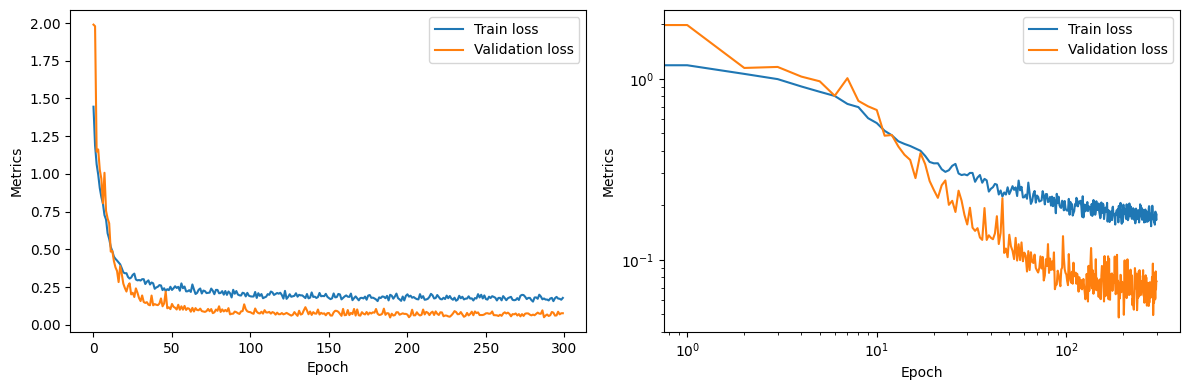

In [7]:
from ptmelt.utils.visualization import plot_history

# Plot the training history
plot_history(history, metrics=["loss"], plot_log=True)

In [8]:
from ptmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(ann_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(ann_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(ann_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

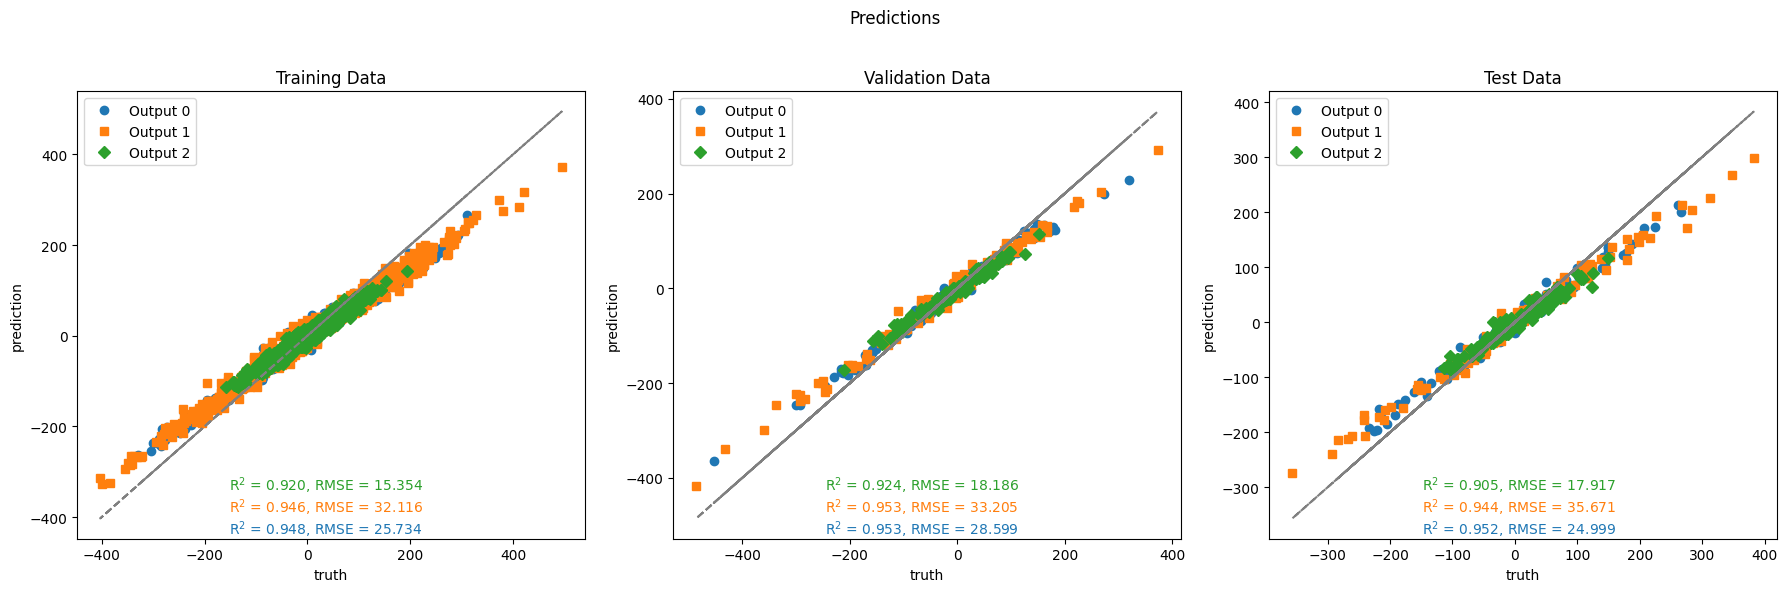

In [9]:
from ptmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

In [10]:
from ptmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(ann_model, x_train, y_normalizer=y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(ann_model, x_val, y_normalizer=y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(ann_model, x_test, y_normalizer=y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

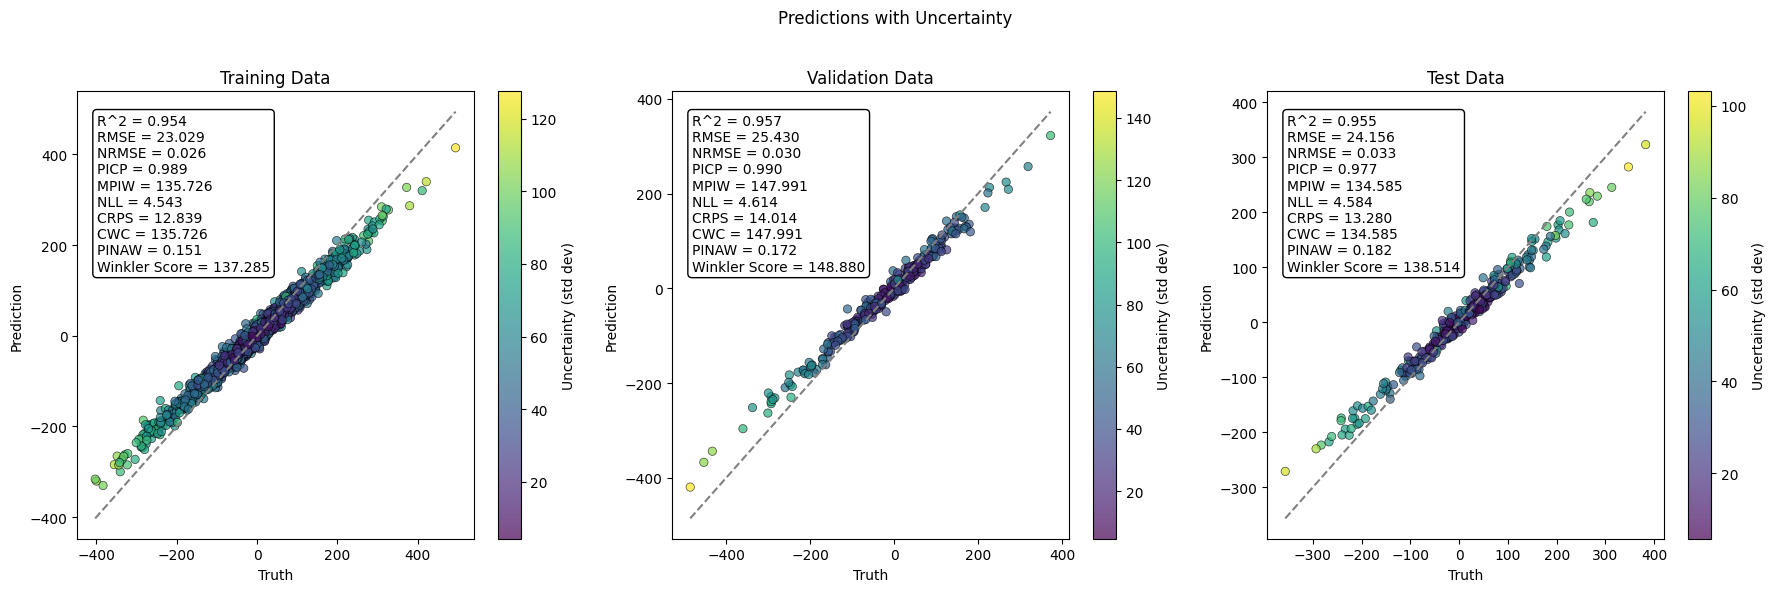

In [11]:
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    metrics_to_display=None, # Display all metrics
)

## Residual Neural Network (ResNet)
Create and train a ResNet using PT-MELT.

In [12]:
from ptmelt.models import ResidualNeuralNetwork

# Create the model
resnet_model = ResidualNeuralNetwork(
    num_features=n_features,
    num_outputs=n_targets,
    width=width,
    depth=depth,
    layers_per_block=layers_per_block,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    batch_norm_type=batch_norm_type,
    pre_activation=True,
    post_add_activation=False,
    output_activation=output_activation,
)

# Build the model and print the summary
resnet_model.build()
print(summary(resnet_model, input_size=(1, n_features)))

# Define the loss function and optimizer for training
criterion = resnet_model.get_loss_fn(loss="mse", reduction="mean")
optimizer = optim.Adam(resnet_model.parameters(), lr=learn_rate)


Layer (type:depth-idx)                   Output Shape              Param #
ResidualNeuralNetwork                    [1, 3]                    --
├─ModuleDict: 1-1                        --                        --
│    └─Dropout: 2-1                      [1, 10]                   --
│    └─ResidualBlock: 2-2                [1, 8]                    --
│    │    └─ModuleDict: 3-1              --                        160
│    └─DefaultOutput: 2-3                [1, 3]                    --
│    │    └─Linear: 3-2                  [1, 3]                    27
│    │    └─Identity: 3-3                [1, 3]                    --
Total params: 187
Trainable params: 187
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


/Users/nwimer/miniconda3/envs/pt-melt/lib/python3.12/site-packages/ptmelt/models.py:312: UserWarning: Warning: depth 2 is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(
/Users/nwimer/miniconda3/envs/pt-melt/lib/python3.12/site-packages/ptmelt/blocks.py:152: UserWarning: Warning: Number of layers 2 is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(


In [13]:
# Fit the model using the built-in training loop
resnet_model.fit(
    train_dl = dataloader,
    val_dl = dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = resnet_model.history

  4%|▍         | 13/300 [00:00<00:02, 129.18it/s]

Epoch 10, Loss: 0.6999, Val Loss: 0.8428
Epoch 20, Loss: 0.3646, Val Loss: 0.2507


  9%|▉         | 28/300 [00:00<00:01, 137.23it/s]

Epoch 30, Loss: 0.2330, Val Loss: 0.1109


 19%|█▉        | 58/300 [00:00<00:01, 141.98it/s]

Epoch 40, Loss: 0.2104, Val Loss: 0.1387
Epoch 50, Loss: 0.1883, Val Loss: 0.0722
Epoch 60, Loss: 0.1817, Val Loss: 0.0768


 29%|██▉       | 88/300 [00:00<00:01, 143.89it/s]

Epoch 70, Loss: 0.1717, Val Loss: 0.0735
Epoch 80, Loss: 0.1586, Val Loss: 0.0527
Epoch 90, Loss: 0.1668, Val Loss: 0.0659


 39%|███▉      | 118/300 [00:00<00:01, 144.38it/s]

Epoch 100, Loss: 0.1327, Val Loss: 0.0721
Epoch 110, Loss: 0.1565, Val Loss: 0.0678
Epoch 120, Loss: 0.1327, Val Loss: 0.0571


 49%|████▉     | 148/300 [00:01<00:01, 145.32it/s]

Epoch 130, Loss: 0.1599, Val Loss: 0.0526
Epoch 140, Loss: 0.1377, Val Loss: 0.0575
Epoch 150, Loss: 0.1362, Val Loss: 0.0580


 59%|█████▉    | 178/300 [00:01<00:00, 145.56it/s]

Epoch 160, Loss: 0.1458, Val Loss: 0.0588
Epoch 170, Loss: 0.1497, Val Loss: 0.0643
Epoch 180, Loss: 0.1604, Val Loss: 0.0598


 69%|██████▉   | 208/300 [00:01<00:00, 145.59it/s]

Epoch 190, Loss: 0.1494, Val Loss: 0.0635
Epoch 200, Loss: 0.1493, Val Loss: 0.0555
Epoch 210, Loss: 0.1511, Val Loss: 0.0787


 79%|███████▉  | 238/300 [00:01<00:00, 145.70it/s]

Epoch 220, Loss: 0.1415, Val Loss: 0.0823
Epoch 230, Loss: 0.1393, Val Loss: 0.0651
Epoch 240, Loss: 0.1518, Val Loss: 0.0804


 89%|████████▉ | 268/300 [00:01<00:00, 143.31it/s]

Epoch 250, Loss: 0.1228, Val Loss: 0.0639
Epoch 260, Loss: 0.1332, Val Loss: 0.0874
Epoch 270, Loss: 0.1422, Val Loss: 0.0594


 99%|█████████▉| 298/300 [00:02<00:00, 144.50it/s]

Epoch 280, Loss: 0.1336, Val Loss: 0.0737
Epoch 290, Loss: 0.1364, Val Loss: 0.0597


100%|██████████| 300/300 [00:02<00:00, 143.96it/s]

Epoch 300, Loss: 0.1411, Val Loss: 0.0652


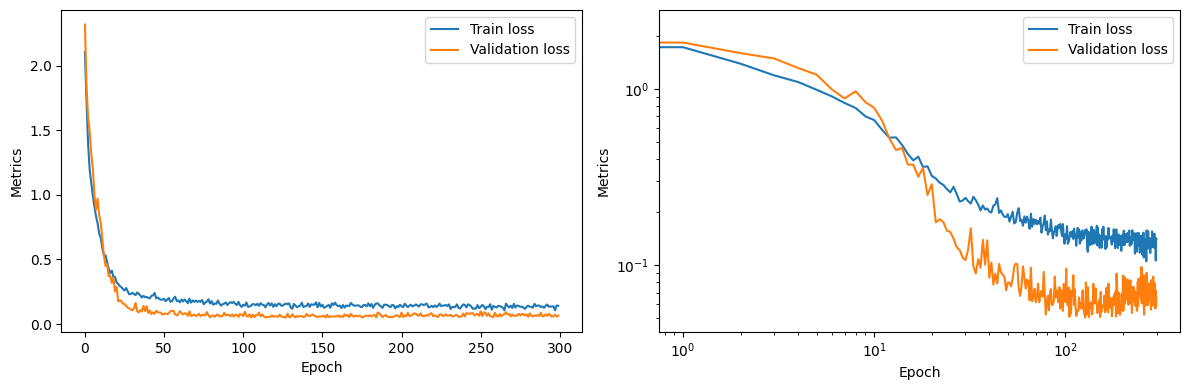

In [14]:
from ptmelt.utils.visualization import plot_history

# Plot the training history
plot_history(history, metrics=["loss"], plot_log=True)

In [15]:
from ptmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(resnet_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(resnet_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(resnet_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

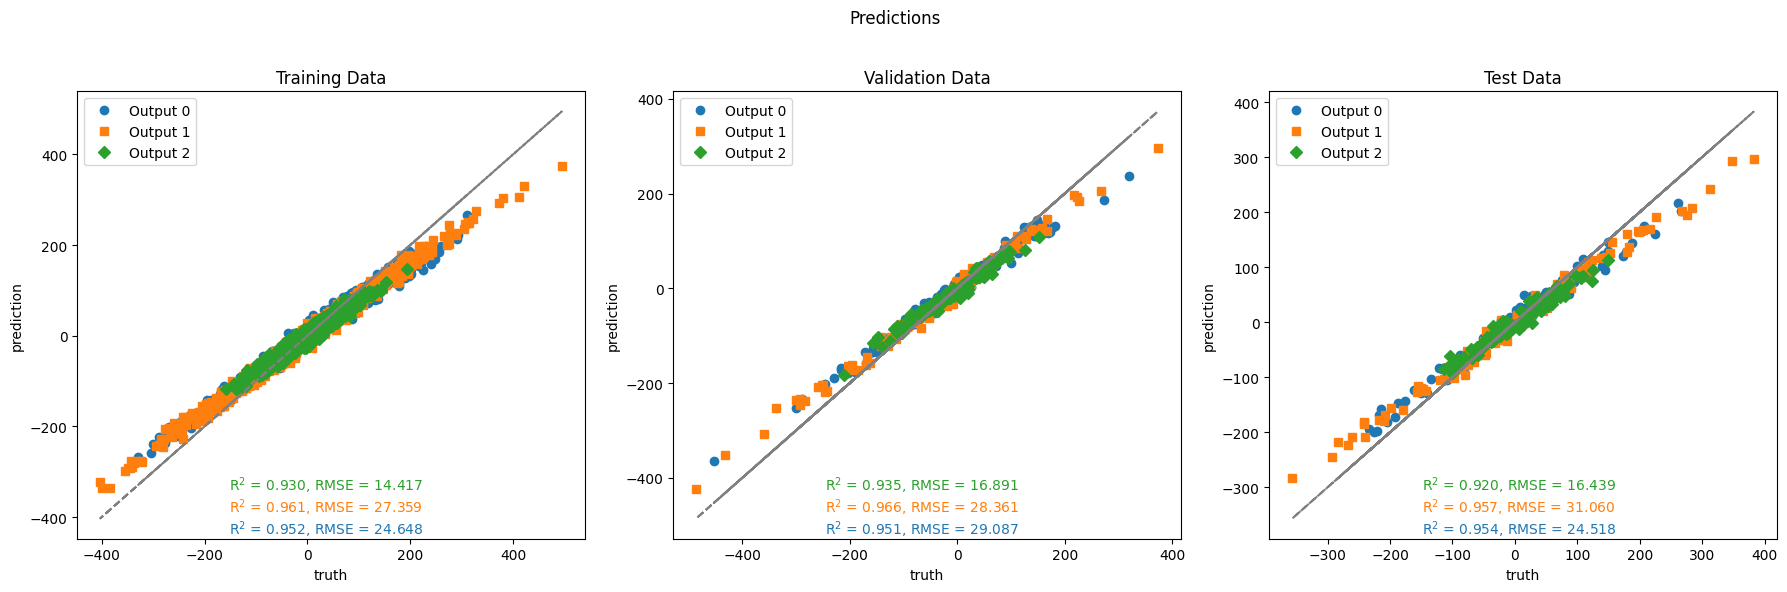

In [16]:
from ptmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

In [17]:
from ptmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(resnet_model, x_train, y_normalizer=y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(resnet_model, x_val, y_normalizer=y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(resnet_model, x_test, y_normalizer=y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

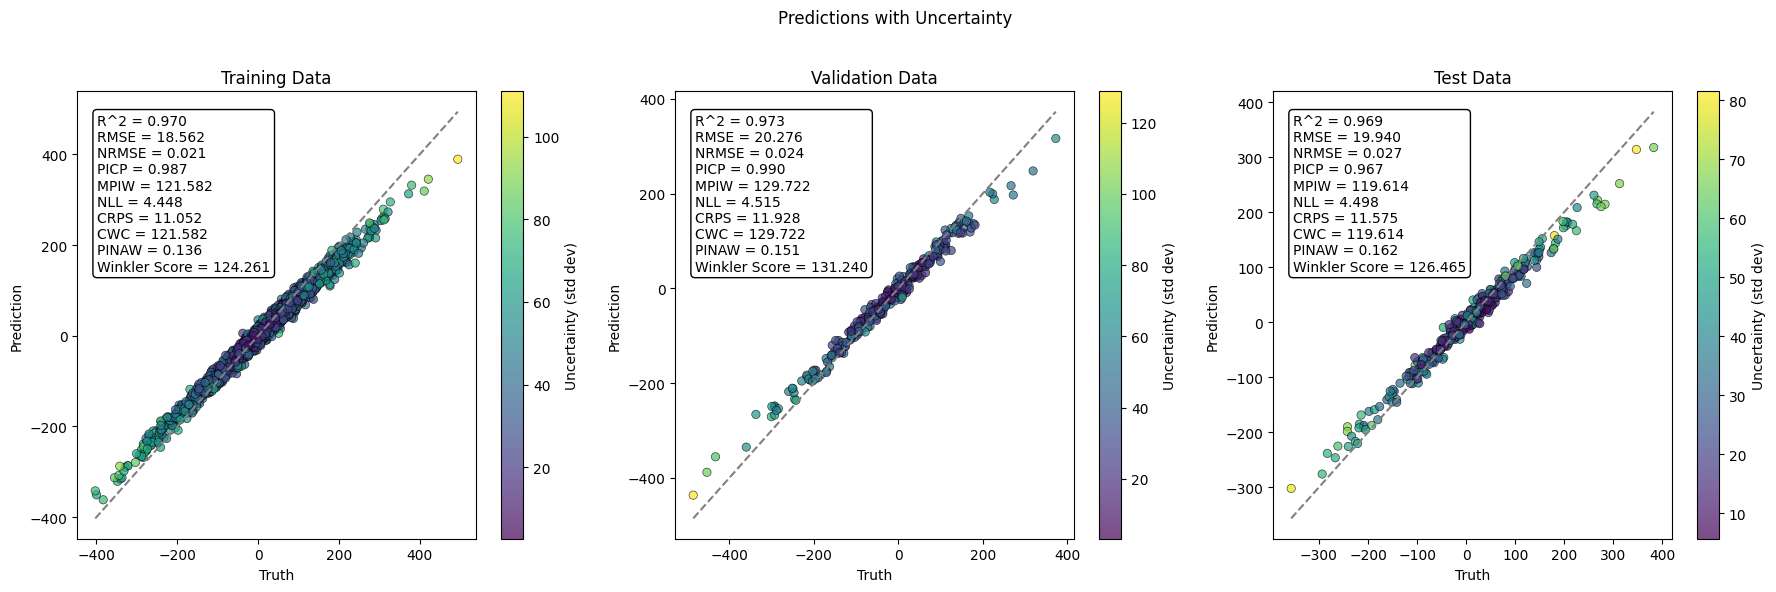

In [18]:
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    metrics_to_display=None, # Display all metrics
)

# Mixture Density Network

Test the MDN with varying numbers of mixtures (when mixtures=1, it is a heteroscedastic NN)

In [24]:
from ptmelt.models import ArtificialNeuralNetwork
from torchinfo import summary
from torch import nn, optim

# Create the model
mdn_model = ArtificialNeuralNetwork(
    num_features=n_features,
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=0.0, # Remove input dropout
    dropout=0.0, # Remove dropout
    batch_norm=batch_norm,
    batch_norm_type=batch_norm_type,
    output_activation=output_activation,
    num_mixtures=1,
)

# Build the model and print the summary
mdn_model.build()
print(summary(mdn_model, input_size=(1, n_features)))

# Define the loss function and optimizer for training
criterion = mdn_model.get_loss_fn()
optimizer = optim.Adam(mdn_model.parameters(), lr=learn_rate)

Layer (type:depth-idx)                   Output Shape              Param #
ArtificialNeuralNetwork                  [1, 7]                    --
├─ModuleDict: 1-1                        --                        --
│    └─DenseBlock: 2-1                   [1, 8]                    --
│    │    └─ModuleDict: 3-1              --                        160
│    └─MixtureDensityOutput: 2-2         [1, 7]                    --
│    │    └─Linear: 3-2                  [1, 1]                    9
│    │    └─Softmax: 3-3                 [1, 1]                    --
│    │    └─Linear: 3-4                  [1, 3]                    27
│    │    └─Identity: 3-5                [1, 3]                    --
│    │    └─Linear: 3-6                  [1, 3]                    27
│    │    └─Identity: 3-7                [1, 3]                    --
Total params: 223
Trainable params: 223
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (M

/Users/nwimer/miniconda3/envs/pt-melt/lib/python3.12/site-packages/ptmelt/models.py:158: UserWarning: Mixture Density Networks require the use of the MixtureDensityLoss class. The loss function will be set to automatically.
  warnings.warn(


In [25]:
# Fit the model using the built-in training loop
mdn_model.fit(
    train_dl = dataloader,
    val_dl = dataloader_val,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=n_epochs,
)

history = mdn_model.history

  7%|▋         | 20/300 [00:00<00:04, 64.82it/s]

Epoch 10, Loss: 3.3261, Val Loss: 3.6988
Epoch 20, Loss: 3.1829, Val Loss: 3.5085


 14%|█▎        | 41/300 [00:00<00:03, 66.25it/s]

Epoch 30, Loss: 2.9009, Val Loss: 3.0589
Epoch 40, Loss: 2.4045, Val Loss: 2.4766


 21%|██        | 62/300 [00:00<00:03, 65.80it/s]

Epoch 50, Loss: 2.0690, Val Loss: 2.2355
Epoch 60, Loss: 1.8057, Val Loss: 2.2164


 28%|██▊       | 83/300 [00:01<00:03, 65.08it/s]

Epoch 70, Loss: 1.6270, Val Loss: 1.7778
Epoch 80, Loss: 1.5018, Val Loss: 1.7421


 32%|███▏      | 97/300 [00:01<00:03, 66.19it/s]

Epoch 90, Loss: 1.3991, Val Loss: 1.7154
Epoch 100, Loss: 1.3397, Val Loss: 1.6524


 39%|███▉      | 118/300 [00:01<00:02, 64.58it/s]

Epoch 110, Loss: 1.2512, Val Loss: 1.6824
Epoch 120, Loss: 1.2161, Val Loss: 1.4406


 46%|████▋     | 139/300 [00:02<00:02, 61.40it/s]

Epoch 130, Loss: 1.1687, Val Loss: 1.3004
Epoch 140, Loss: 1.1357, Val Loss: 1.3963


 53%|█████▎    | 160/300 [00:02<00:02, 59.51it/s]

Epoch 150, Loss: 1.1183, Val Loss: 1.3228
Epoch 160, Loss: 1.0905, Val Loss: 1.2314


 60%|██████    | 181/300 [00:02<00:01, 62.68it/s]

Epoch 170, Loss: 1.0757, Val Loss: 1.1649
Epoch 180, Loss: 1.0657, Val Loss: 1.1517


 67%|██████▋   | 202/300 [00:03<00:01, 62.00it/s]

Epoch 190, Loss: 1.0492, Val Loss: 1.1787
Epoch 200, Loss: 1.0370, Val Loss: 1.2596


 74%|███████▍  | 223/300 [00:03<00:01, 63.93it/s]

Epoch 210, Loss: 1.0262, Val Loss: 1.1434
Epoch 220, Loss: 1.0172, Val Loss: 1.1475


 79%|███████▉  | 237/300 [00:03<00:00, 64.29it/s]

Epoch 230, Loss: 1.0114, Val Loss: 1.1009
Epoch 240, Loss: 1.0048, Val Loss: 1.0665


 86%|████████▌ | 258/300 [00:04<00:00, 65.98it/s]

Epoch 250, Loss: 0.9940, Val Loss: 1.1127
Epoch 260, Loss: 0.9931, Val Loss: 1.1895


 93%|█████████▎| 279/300 [00:04<00:00, 65.06it/s]

Epoch 270, Loss: 0.9856, Val Loss: 1.1188
Epoch 280, Loss: 0.9860, Val Loss: 1.0595


100%|██████████| 300/300 [00:04<00:00, 63.67it/s]

Epoch 290, Loss: 0.9895, Val Loss: 1.0838
Epoch 300, Loss: 0.9799, Val Loss: 1.0827


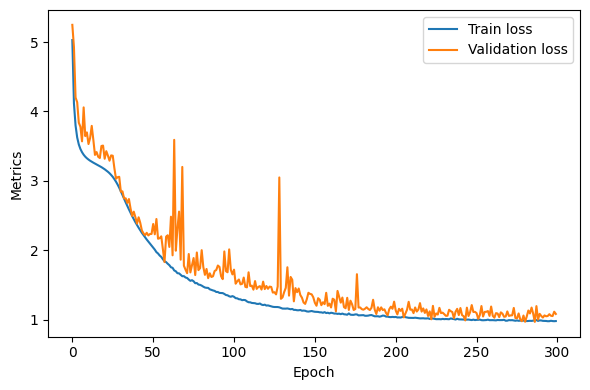

In [26]:
from ptmelt.utils.visualization import plot_history

# Plot the training history
plot_history(history, metrics=["loss"], plot_log=False)

In [27]:
from ptmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(mdn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(mdn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(mdn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

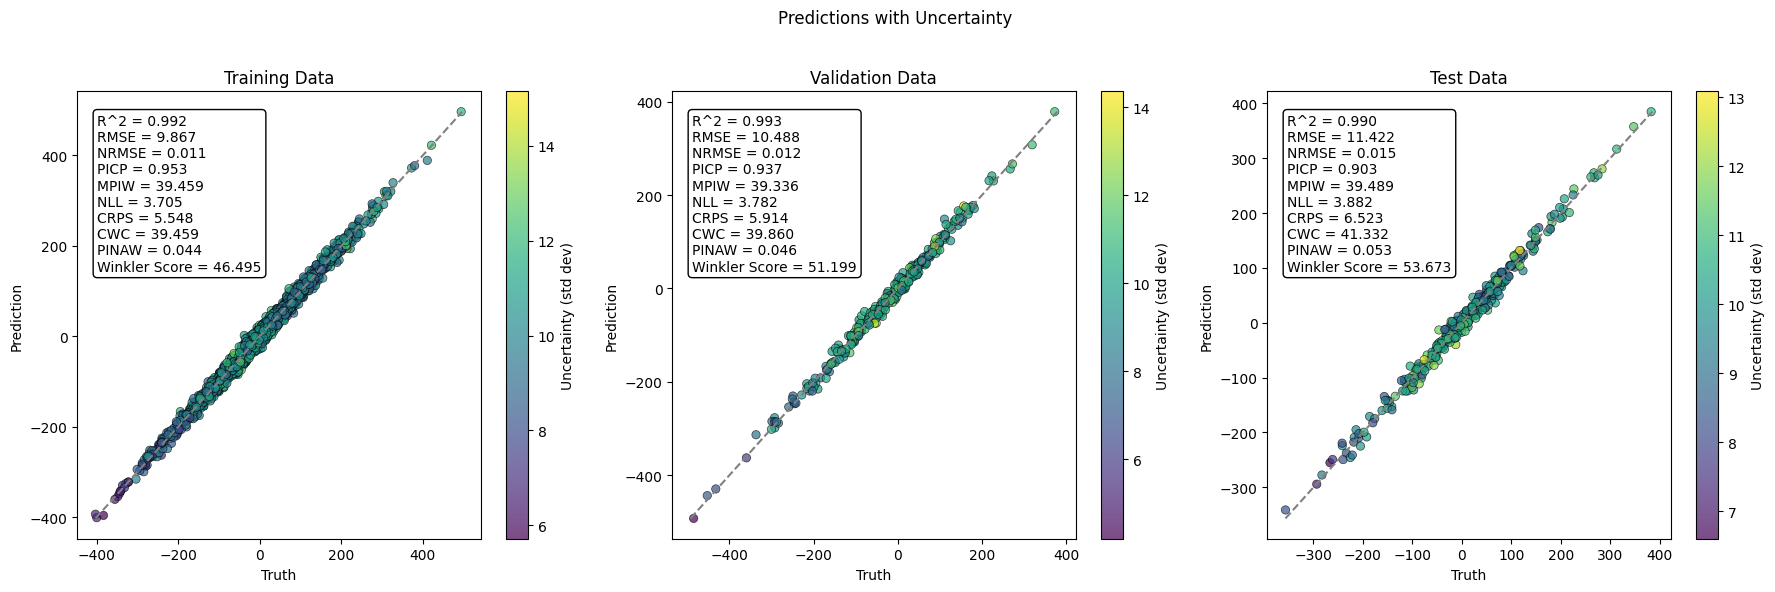

In [28]:
from ptmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_val, pred_val_std, y_val_real,
    pred_test, pred_test_std, y_test_real,
    metrics_to_display=None, # Display all metrics
)

# Bayesian Neural Network (BNN)

coming soon...